**GitHub Repository:** https://github.com/jperrin74/Deep-Learning-Final-Project

**Project and Dataset Description:** The purpose of this project is to build model that can perform multi-class image classification of clothing items. The model will be trained on the training data of the dataset, and classify each unseen 28 by 28 pixels grayscale unseen image as one of the ten possible class labels (T-Shirt, Trouser, Boot, etc.). The dataset used for this project is the Fashion-MNIST dataset provided by Kaggle. The dataset contains 60,000 training sets and 10,000 test samples of the 28 by 28 pixels images. The create the best performing model, the use of a Dense Neural Network (DNN) will be compared to the use of Convolutional Neural Network (CNN). It is hypothesized that the CNN will be a better performing architecture for the model, as the type of architecture is known for being used for image data, in comparision to the DNN flatting the images into a 1D vector, which removes spatial information. In addition, it is hypothesized that the pixels in center of the image is more important for classification than the edges. This hypothesis is based on the clothing item being in the center of each image, with the edges being background pixels, with a value of 0. In addition, the use of a CNN is further justified by this hypothesis, as it has the ablity to develop a filter during training to focus on the center of the image and ignore the edges.

**Import Libraries and Mount Google Drive**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

#Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Load Data**

In [ ]:
try:
    train_csv_path = '/content/drive/MyDrive/Deep_Learning_Final_Project/fashion-mnist_train.csv'
    test_csv_path = '/content/drive/MyDrive/Deep_Learning_Final_Project/fashion-mnist_test.csv'

    # Loading datasets using pandas
    train_df = pd.read_csv(train_csv_path)
    test_df = pd.read_csv(test_csv_path)
    print("CSV files loaded successfully.")

except FileNotFoundError:
    print("ERROR: CSV files not found. Please check the file paths.")
    exit()

# Separate labels from pixel data
# The first column 'label' is the target, the rest are pixel values.
y_train = train_df['label'].values
x_train_flat = train_df.drop('label', axis=1).values

y_test = test_df['label'].values
x_test_flat = test_df.drop('label', axis=1).values

# Reshaping the flat pixel data (784 pixels) into 28x28 images
x_train = x_train_flat.reshape(-1, 28, 28)
x_test = x_test_flat.reshape(-1, 28, 28)

# Define class names for plotting and reports
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print("Data extracted from dataframes and reshaped.")
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

CSV files loaded successfully.
Data extracted from dataframes and reshaped.
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)


**Exploratory Data Analysis**

The dataset contains 785 columns with the first label being the target variable, as it the integer that defines the clothing class, and the 784 othe columns being pixel values of each image. The pixel values range from 0 (white) to 255 (black), defining the intensity of each pixel in the 28 by 28 grid data sample.

/tmp/ipython-input-15-373712113.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="viridis")


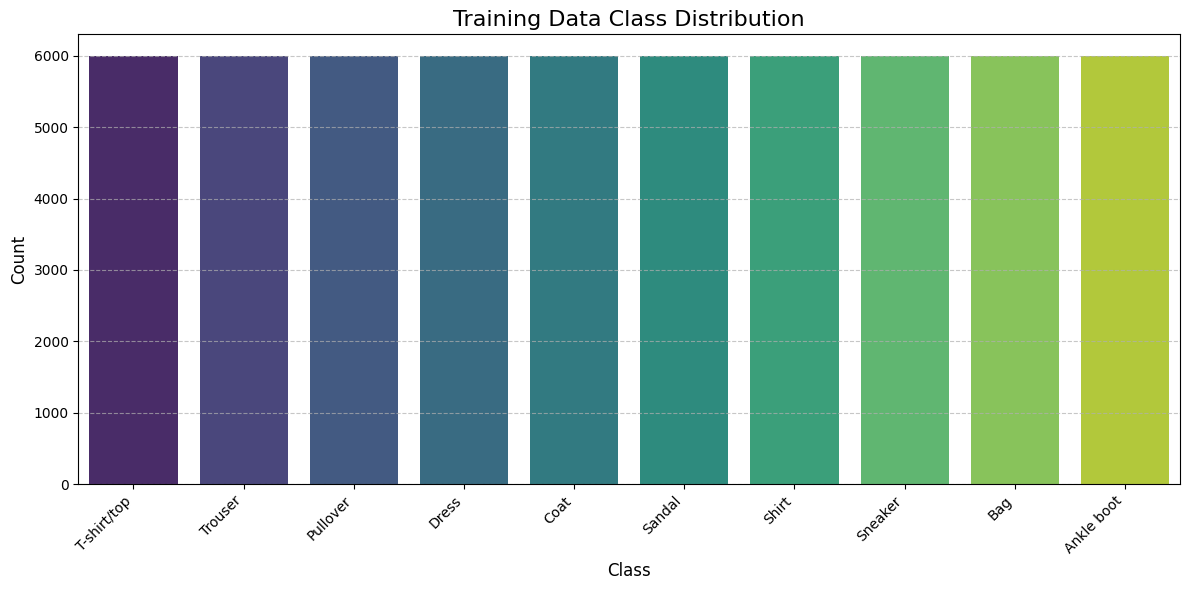

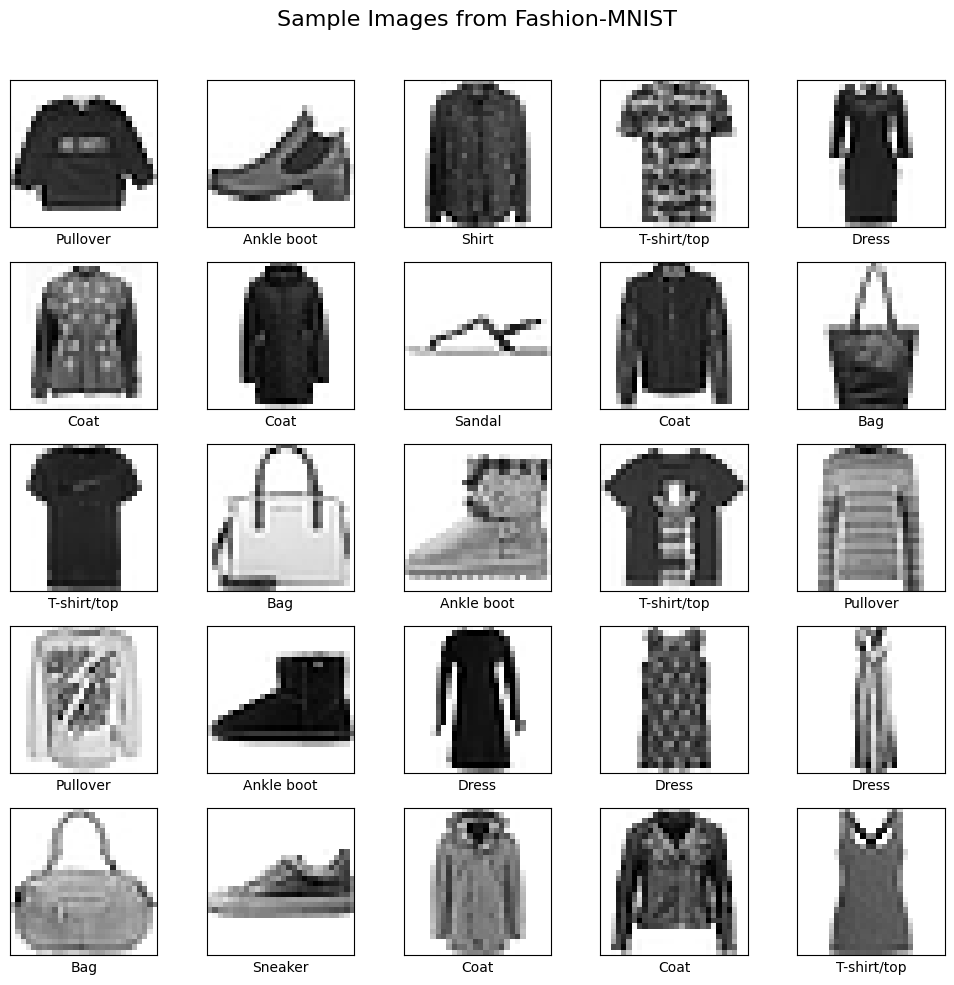

In [ ]:
# 1. Visualize class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x=y_train, palette="viridis")
plt.title('Training Data Class Distribution', fontsize=16)
plt.xticks(ticks=range(10), labels=class_names, rotation=45, ha="right")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Visualize sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.suptitle("Sample Images from Fashion-MNIST", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Based on the countplot, the training set is perfectly balanced There is 10 classes, with 6,000 images in each class. This removes the need to clean the data, and signifies that the model will not become biased towards any specific class. In addition, it can be seen in the sample images that there is a high degree of spatial correlation. Each pixel is depenent from the neighboring pixels. By knowing this, it justifies the current hypothesis that the CNN architecture will showcase higher performance of the model, as high spatial correlation is necessary for CNNs.

**Data Preprocessing**

The data needed to be normalized from a 0 to 255 pixel value range to a 0 to 1 pixel range. This is achieved by dividing both the train and test ranges by 255. Doing this allows the neural network to learn and classify more naturally, as all the features are on the same scale, as well make the model converge faster. In addition, the integrer labels needed to transformed into binary vectors. This was done using One-Hot Encoding, as the categorical crossentropy loss function requires binary vectors to compare the model output to the true output.

In [ ]:
# Normalize pixel values to be between 0 and 1 for binary classification
x_train_norm = x_train.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Reshape data for the CNN
x_train_cnn = np.expand_dims(x_train_norm, -1)
x_test_cnn = np.expand_dims(x_test_norm, -1)

print(f"Shape of normalized training data for CNN: {x_train_cnn.shape}")
print(f"Shape of one-hot encoded training labels: {y_train_cat.shape}")

Shape of normalized training data for CNN: (60000, 28, 28, 1)
Shape of one-hot encoded training labels: (60000, 10)


**Model Building And Analysis Using DNN And CNN**

The model's best performance will evaluated by comparing the performance of the DNN to the CNN. Both the DNN and CNN will be trained on the same number of epochs. The DNN flattens each image to a vector based on the 784 elements. By doing so, the images lose the 2D spatial relationships of the pixels, and only learns an average of each pixel's activity. The CNN processes image in its original 2D format, using layers such as Conv2D to detect and learn the patterns of each class.

The hyperparamters used for the model were the specific Dropout values and architecture depth. The use of the Dropout layers allows the model to randomly deactivate neurons during training. By doing so, the model network learns different features throughout the entire training process, reducing the possiblity of overfitting the data. In addition, the CNN architecture used two convolutional and pooling blocks. These blocks train the model to learn simple features such as edges in the first layer, then combine the layer with more complex features, such as patterns on the clothing items, in the second layer. Furthermore, the adam optimizer and relu activation function were used based on previous assignments using them and being effective.

In [ ]:
# Model 1: Baseline Dense Neural Network (DNN)
print("\nBuilding Baseline DNN Model")
dnn_model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')])
dnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dnn_model.summary()

print("\nTraining the DNN Model:")
dnn_history = dnn_model.fit(x_train_norm, y_train_cat, epochs=20, validation_split=0.2, batch_size=64, verbose=1)

# Model 2: Optimized Convolutional Neural Network (CNN)
print("\nBuilding Optimized CNN Model")
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')])
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

print("\nTraining the CNN Model:")
cnn_history = cnn_model.fit(x_train_cnn, y_train_cat, epochs=20, validation_split=0.2, batch_size=64, verbose=1)


Building Baseline DNN Model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)


Training the DNN Model:
Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7516 - loss: 0.7125 - val_accuracy: 0.8469 - val_loss: 0.4333
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8571 - loss: 0.4044 - val_accuracy: 0.8611 - val_loss: 0.3942
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8723 - loss: 0.3564 - val_accuracy: 0.8668 - val_loss: 0.3710
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8815 - loss: 0.3257 - val_accuracy: 0.8728 - val_loss: 0.3593
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8870 - loss: 0.3110 - val_accuracy: 0.8752 - val_loss: 0.3393
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8952 - loss: 0.2891 - val_accuracy: 0.8802 - val_loss: 0.3314
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9003 - loss: 0.2699 - val_accuracy: 0.8797 - val_loss: 0.3323
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9059 - loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)


Training the CNN Model:
Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6476 - loss: 0.9602 - val_accuracy: 0.8499 - val_loss: 0.4319
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8237 - loss: 0.4865 - val_accuracy: 0.8683 - val_loss: 0.3674
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8491 - loss: 0.4188 - val_accuracy: 0.8808 - val_loss: 0.3276
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8638 - loss: 0.3793 - val_accuracy: 0.8884 - val_loss: 0.3140
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8718 - loss: 0.3521 - val_accuracy: 0.8944 - val_loss: 0.2919
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8782 - loss: 0.3332 - val_accuracy: 0.9011 - val_loss: 0.2779
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8869 - loss: 0.3130 - val_accuracy: 0.9030 - val_loss: 0.2694
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8860 - loss: 

**Model Evaluations**

Baseline DNN Test Accuracy: 89.06%
Optimized CNN Test Accuracy: 91.40%


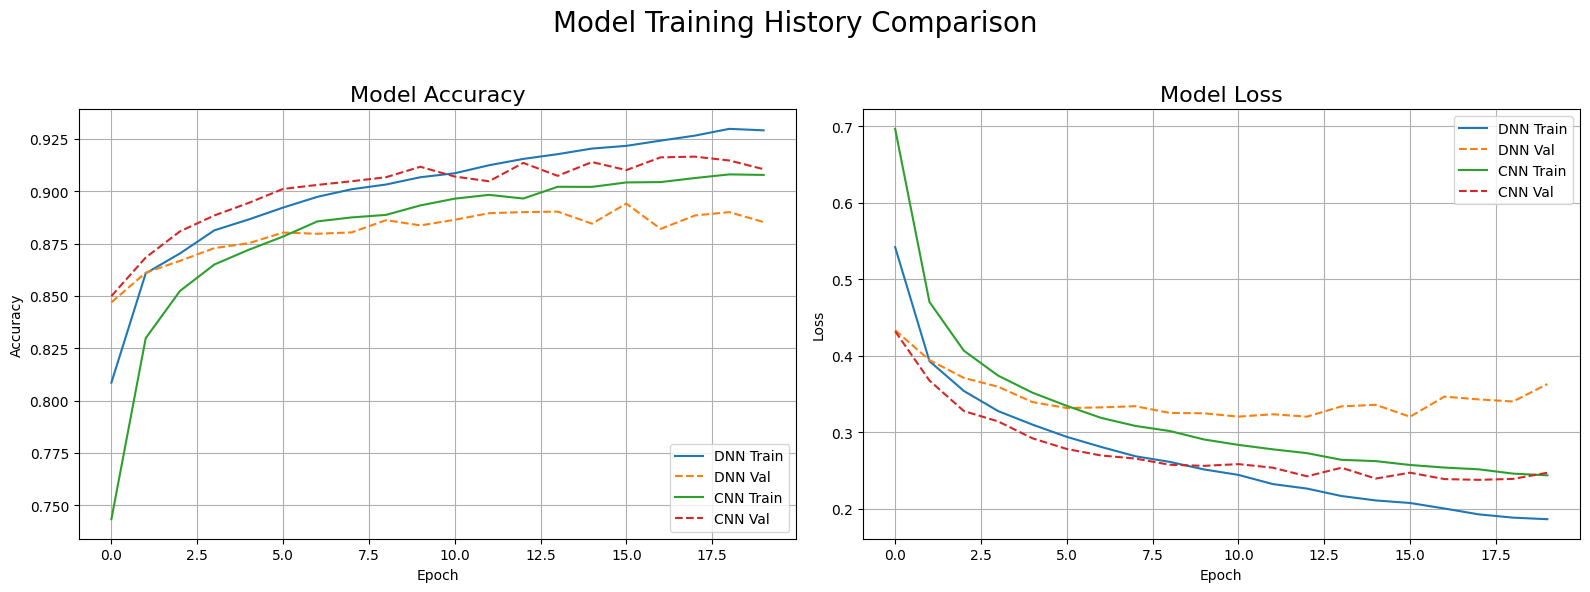


Detailed Analysis of the CNN Model
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix for the CNN:
----------------------------


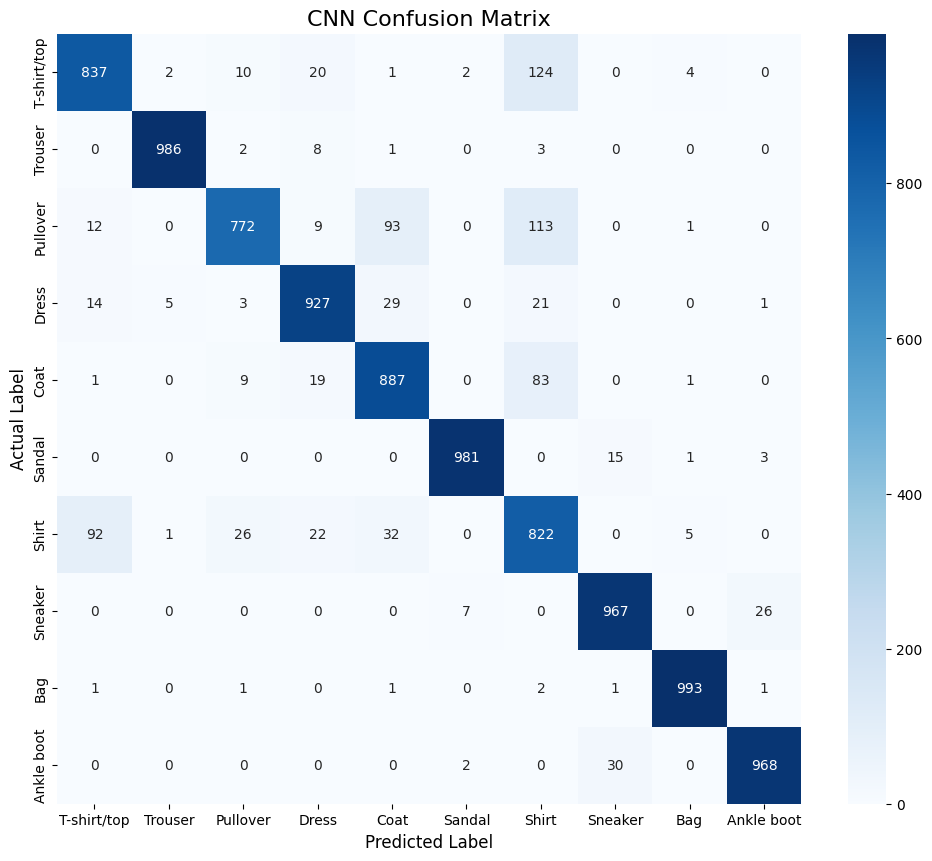


Classification report for the CNN:

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.84      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.94      0.77      0.85      1000
       Dress       0.92      0.93      0.92      1000
        Coat       0.85      0.89      0.87      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.70      0.82      0.76      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



In [ ]:
dnn_loss, dnn_accuracy = dnn_model.evaluate(x_test_norm, y_test_cat, verbose=0)
cnn_loss, cnn_accuracy = cnn_model.evaluate(x_test_cnn, y_test_cat, verbose=0)
print(f"Baseline DNN Test Accuracy: {dnn_accuracy*100:.2f}%")
print(f"Optimized CNN Test Accuracy: {cnn_accuracy*100:.2f}%")

# Plotting training history
def plot_history(histories, names):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val', linestyle='--')
    plt.title('Model Accuracy', fontsize=16)
    plt.ylabel('Accuracy'); plt.xlabel('Epoch'); plt.legend(loc='lower right'); plt.grid(True)
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val', linestyle='--')
    plt.title('Model Loss', fontsize=16)
    plt.ylabel('Loss'); plt.xlabel('Epoch'); plt.legend(loc='upper right'); plt.grid(True)
    plt.suptitle("Model Training History Comparison", fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_history([dnn_history, cnn_history], ['DNN', 'CNN'])

print("\nDetailed Analysis of the CNN Model")
y_pred_cnn = cnn_model.predict(x_test_cnn)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)

# 1. Confusion matrix
print("Confusion matrix for the CNN:")
print("----------------------------")
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix', fontsize=16); plt.ylabel('Actual Label', fontsize=12); plt.xlabel('Predicted Label', fontsize=12); plt.show()

# 2. Classification report
print("\nClassification report for the CNN:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

**Results analysis:** Based on the training history comparision and classification report, the CNN had a 91% test accuracy and the DNN had 88% test accuracy. From the test accuracy results, it was determined that the CNN architecture was the superior model. As there were 10,000 test data samples, with 1,000 of each class, and the CNN accuracy being 3% higher, this means that the CNN model was able to correctly identify 300 more images over the DNN model.

Looking at the confusion matrix and classification report of the CNN model, the model was able to distinguish the trousers the best (99% precision), followed closely by sandals (99% precision, but slightly lower recall and F1 score), and bags (97% precision). However, the model had difficulty distinguishing between the upper body clothing: T-shirt/top, Shirt, and Pullover. This was reflected by the low recall score of the Shirt class and the overconfidence of the T-shirt/top class. This is due to the model over guessing the T-shirt/top class caused by misclassifying when determining the differences between the similar classes (Shirt, Pullover, and Coat).

**Conclusion**

Based on the results and overall creation of the model, the hypothesis was proven to be correct: the CNN architecture is the higher performing acrchitecture for the project. With a 91% test accuracy, and high values for precision, recall, and F1-score on average for each class of the test data, it can be determined that a CNN model is best for this data set. To improve this model in the future, it would be best to fine tune the training data for the Shirt, Pullover, and T-shirt/top classes. The model had the most difficulty distinguishing these classes, likely due to each having a similar shape and features. In order for the model to be able to evaluate and distinguish these classes with higher precision, using data augmentation to create more varied examples for differentiation of these types with more fine details (such the knit texture of a pullover, the buttons of a shirt, and the simple collar of a T-shirt) would be best. In addition, using a more advanced architecture such as residual network could depict the more fine details of the clothing by utilizing a skip connection layer to create more deep layers for texture learning during training.